# Bayesian Models for SDSS data

## Libraries

In [42]:
import astroNN
import os
from astroNN.datasets import load_galaxy10
from astroNN.datasets.galaxy10 import galaxy10cls_lookup
import tensorflow_probability as tfp 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random
from model import loss_fn

tfd = tfp.distributions
tfpl = tfp.layers

plt.rcParams['figure.figsize'] = (10, 6)

## Tf and Tfp versions

In [2]:
print("Tensorflow Version: ", tf.__version__)
print("Tensorflow Probability Version: ", tfp.__version__)

Tensorflow Version:  2.5.0
Tensorflow Probability Version:  0.13.0


## Load data

In [3]:
images, labels = load_galaxy10()
labels = labels.astype(np.float32)
labels = to_categorical(labels)
images = images.astype(np.float32)
images = images/255 

C:\SPB_DATA\.astroNN\datasets\Galaxy10.h5 was found!


## Visualise input-output pairs

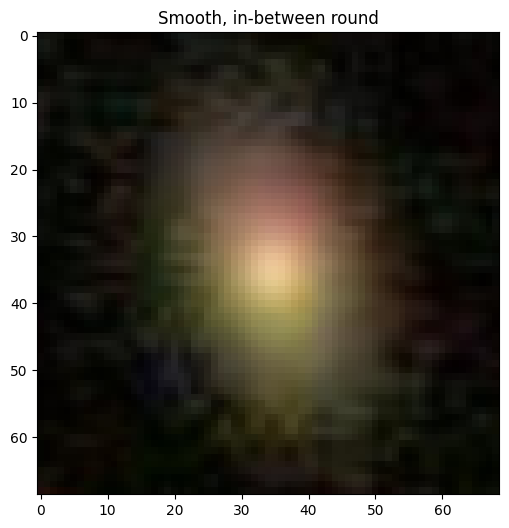

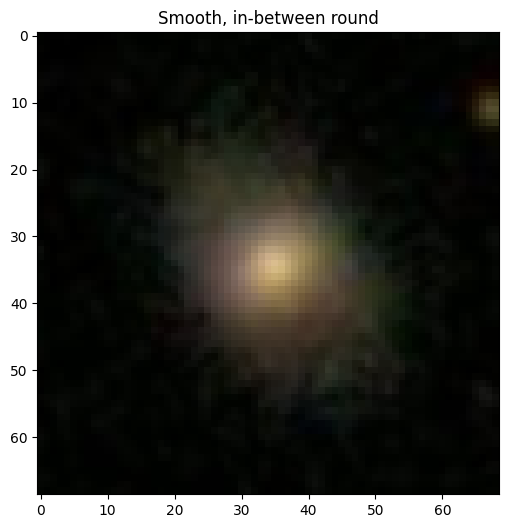

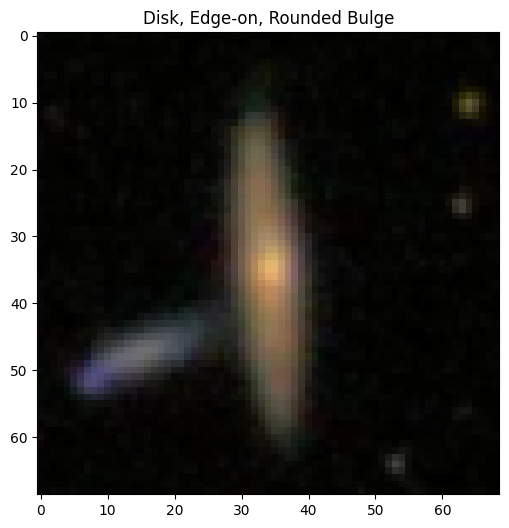

In [4]:
def show_image(image_data,label):
    label = galaxy10cls_lookup(int(label))
    plt.imshow(image_data)
    plt.title(label)
    plt.show()
for i in range(3):
    show_image(images[i], np.argmax(labels[i]))

## Train-Val-Test split

We are using a 70-15-15 split

In [5]:
X_train, X_val_test, y_train, y_val_test = train_test_split(images, labels, test_size = 0.30)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.50)

In [6]:
print(images.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(21785, 69, 69, 3)
(15249, 69, 69, 3)
(15249, 10)
(3268, 69, 69, 3)
(3268, 10)
(3268, 69, 69, 3)
(3268, 10)


## Utility functions

### Negative log likelihood

In [7]:
def nll(y_true, y_pred):
    """
    This function should return the negative log-likelihood of each sample
    in y_true given the predicted distribution y_pred. If y_true is of shape 
    [B, E] and y_pred has batch shape [B] and event_shape [E], the output 
    should be a Tensor of shape [B].
    """
    return -y_pred.log_prob(y_true)

### Reparameterized convolution

In [8]:
def get_convolutional_reparameterization_layer(input_shape, divergence_fn , f ,k):
    """
    This function should create an instance of a Convolution2DReparameterization 
    layer according to the above specification. 
    The function takes the input_shape and divergence_fn as arguments, which should 
    be used to define the layer.
    Your function should then return the layer instance.
    """
    layer = tfpl.Convolution2DReparameterization(
                input_shape=input_shape, filters=f, kernel_size=(k, k),
                activation='relu', padding='VALID',
                kernel_prior_fn=tfpl.default_multivariate_normal_fn,
                kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                kernel_divergence_fn=divergence_fn,
                bias_prior_fn=tfpl.default_multivariate_normal_fn,
                bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                bias_divergence_fn=divergence_fn
                )
    
    return layer

## Flipout convolution

In [32]:
def get_convolutional_flipout_layer(input_shape, divergence_fn , f ,k):
    
    layer = tfpl.Convolution2DFlipout(
                input_shape=input_shape, filters=f, kernel_size=(k, k),
                activation='relu', padding='VALID',
                kernel_prior_fn=tfpl.default_multivariate_normal_fn,
                kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                kernel_divergence_fn=divergence_fn,
                bias_prior_fn=tfpl.default_multivariate_normal_fn,
                bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                bias_divergence_fn=divergence_fn
                )
    
    return layer

### Reparameterized dense layer

In [9]:
def get_dense_reparameterization_layer(divergence_fn, units):
    
    layer = tfpl.DenseReparameterization(
                 units = units, activation = None,
                 kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
                 kernel_prior_fn = tfpl.default_multivariate_normal_fn, 
                 bias_prior_fn = tfpl.default_multivariate_normal_fn,
                 bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
                 kernel_divergence_fn = divergence_fn,
                 bias_divergence_fn = divergence_fn)
    
    return layer

### Flipout dense layer

In [33]:
def get_dense_flipout_layer(divergence_fn, units):
    
    layer = tfpl.DenseFlipout(
                 units = units, activation = None,
                 kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
                 kernel_prior_fn = tfpl.default_multivariate_normal_fn, 
                 bias_prior_fn = tfpl.default_multivariate_normal_fn,
                 bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
                 kernel_divergence_fn = divergence_fn,
                 bias_divergence_fn = divergence_fn)
    
    return layer

### Spike and slab distribution for dense variational layer

In [10]:
def spike_and_slab(event_shape, dtype):
    distribution = tfd.Mixture(
        cat=tfd.Categorical(probs=[0.5, 0.5]),
        components=[
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=1.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1),
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=10.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1)],
    name='spike_and_slab')
    return distribution

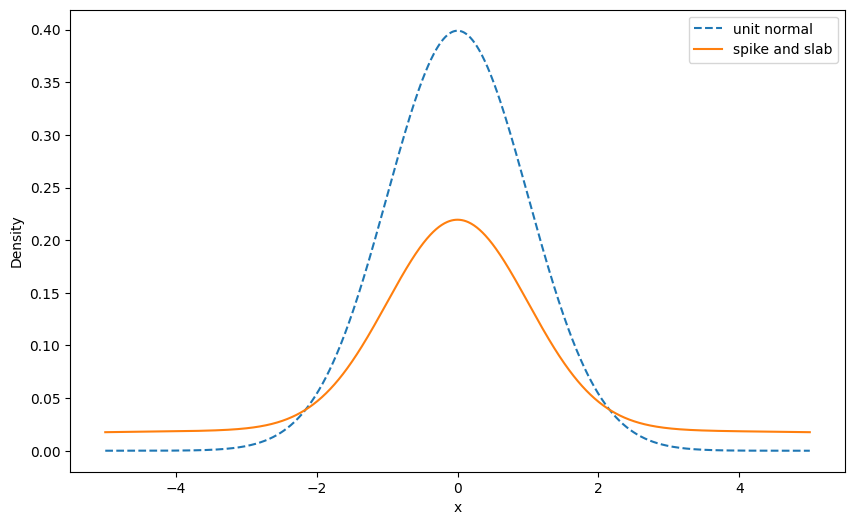

In [11]:
x_plot = np.linspace(-5, 5, 1000)[:, np.newaxis]
plt.plot(x_plot, tfd.Normal(loc=0, scale=1).prob(x_plot).numpy(), label='unit normal', linestyle='--')
plt.plot(x_plot, spike_and_slab(1, dtype=tf.float32).prob(x_plot).numpy(), label='spike and slab')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

### Dense variational layer with its prior and posterior definitions

In [12]:
def get_prior(kernel_size, bias_size, dtype=None):
    """
    This function should create the prior distribution, consisting of the 
    "spike and slab" distribution that is described above. 
    The distribution should be created using the kernel_size, bias_size and dtype
    function arguments above.
    The function should then return a callable, that returns the prior distribution.
    """
    n = kernel_size+bias_size  
    prior_model = Sequential([tfpl.DistributionLambda(lambda t : spike_and_slab(n, dtype))])
    return prior_model

In [13]:
def get_posterior(kernel_size, bias_size, dtype=None):
    """
    This function should create the posterior distribution as specified above.
    The distribution should be created using the kernel_size, bias_size and dtype
    function arguments above.
    The function should then return a callable, that returns the posterior distribution.
    """
    n = kernel_size + bias_size
    return Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype=dtype),
        tfpl.IndependentNormal(n)
    ])

In [14]:
def get_dense_variational_layer(units, prior_fn, posterior_fn, kl_weight):
    """
    This function should create an instance of a DenseVariational layer according 
    to the above specification. 
    The function takes the prior_fn, posterior_fn and kl_weight as arguments, which should 
    be used to define the layer.
    Your function should then return the layer instance.
    """
    return tfpl.DenseVariational(
        units=units, make_posterior_fn=posterior_fn, make_prior_fn=prior_fn, kl_weight=kl_weight
    )

## Set seed and define divergence functions

In [15]:
tf.random.set_seed(0)
divergence_fn = lambda q, p, _ : tfd.kl_divergence(q, p) / X_train.shape[0]

## Model 1

Same architecture as Sarvesh's with fully bayesian layers(dense layers are variational and not reparameterized)

### Build model

In [17]:
bayesian_model_variational = Sequential([
    get_convolutional_reparameterization_layer(
    input_shape=(69, 69, 3), divergence_fn=divergence_fn, f = 32, k =3),
    #MaxPooling2D(pool_size=(2, 2)),
    get_convolutional_reparameterization_layer(
    input_shape=(67, 67, 32), divergence_fn=divergence_fn, f = 64, k =3),
    MaxPooling2D(pool_size=(2, 2)),
    get_convolutional_reparameterization_layer(
    input_shape=(32, 32, 64), divergence_fn=divergence_fn, f = 64, k =3),
    MaxPooling2D(pool_size=(2, 2)),
    get_convolutional_reparameterization_layer(
    input_shape=(15, 15, 64), divergence_fn=divergence_fn, f = 64, k =3),
    MaxPooling2D(pool_size=(2, 2)),
    get_convolutional_reparameterization_layer(
    input_shape=(6, 6, 64), divergence_fn=divergence_fn, f = 64, k =3),
    MaxPooling2D(pool_size=(2, 2)),
    #get_convolutional_reparameterization_layer(
    #input_shape=(57, 57, 8), divergence_fn=divergence_fn, f = 8, k =5),
    #MaxPooling2D(pool_size=(5, 5)),
    Flatten(),
    get_dense_variational_layer(64,
    get_prior, get_posterior, kl_weight=1/X_train.shape[0]),
    get_dense_variational_layer(32,
    get_prior, get_posterior, kl_weight=1/X_train.shape[0]),
    get_dense_variational_layer(10,
    get_prior, get_posterior, kl_weight=1/X_train.shape[0]),
    tfpl.OneHotCategorical(10, convert_to_tensor_fn=tfd.Distribution.mode)
])

In [18]:
print(bayesian_model_variational.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization_5  (None, 67, 67, 32)        1792      
_________________________________________________________________
conv2d_reparameterization_6  (None, 65, 65, 64)        36992     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_reparameterization_7  (None, 30, 30, 64)        73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_reparameterization_8  (None, 13, 13, 64)        73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)         

**As expected, there are 2x the number of parameters -  hence, we shall train for 100 epochs**

### Compile model and train

In [19]:
bayesian_model_variational.compile(loss=nll,
              optimizer=Adam(),
              metrics=['accuracy'],
              experimental_run_tf_function=False)

In [20]:
history_variational_bayes = bayesian_model_variational.fit(x=X_train, y=y_train, batch_size = 32, epochs = 100, validation_data = (X_val,y_val), verbose=True)

Epoch 1/100
477/477 [==============================] - 26s 33ms/step - loss: 71.5173 - accuracy: 0.0995 - val_loss: 45.0455 - val_accuracy: 0.1089
Epoch 2/100
477/477 [==============================] - 14s 29ms/step - loss: 42.1967 - accuracy: 0.1056 - val_loss: 41.6075 - val_accuracy: 0.1227
Epoch 3/100
477/477 [==============================] - 14s 29ms/step - loss: 40.0406 - accuracy: 0.1192 - val_loss: 38.7322 - val_accuracy: 0.1172
Epoch 4/100
477/477 [==============================] - 14s 29ms/step - loss: 38.5881 - accuracy: 0.1035 - val_loss: 37.3487 - val_accuracy: 0.1077
Epoch 5/100
477/477 [==============================] - 14s 29ms/step - loss: 37.1462 - accuracy: 0.1087 - val_loss: 35.9472 - val_accuracy: 0.1080
Epoch 6/100
477/477 [==============================] - 14s 28ms/step - loss: 35.4059 - accuracy: 0.1158 - val_loss: 34.1094 - val_accuracy: 0.1368
Epoch 7/100
477/477 [==============================] - 14s 29ms/step - loss: 34.0136 - accuracy: 0.1254 - val_loss: 33

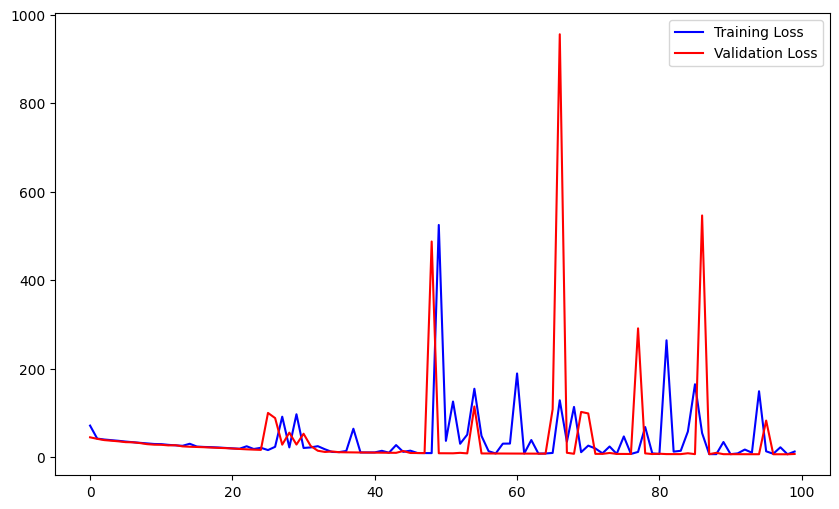

In [22]:
plt.plot(history_variational_bayes.history['loss'],color='b',
label='Training Loss')
plt.plot(history_variational_bayes.history['val_loss'],color='r',
label='Validation Loss')
plt.legend()
plt.show()

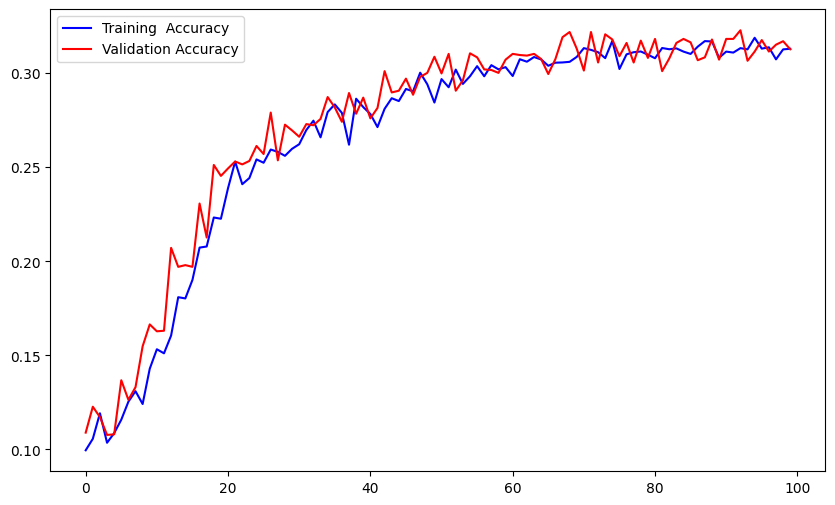

In [23]:
plt.plot(history_variational_bayes.history['accuracy'],color='b',
label='Training  Accuracy')
plt.plot(history_variational_bayes.history['val_accuracy'],color='r',
label='Validation Accuracy')
plt.legend()
plt.show()

## Model 2

Same architecture as Sarvesh's with fully Bayesian layers(dense layers are reparameterized this time)

### Build model

In [24]:
bayesian_model_repar = Sequential([
    get_convolutional_reparameterization_layer(
    input_shape=(69, 69, 3), divergence_fn=divergence_fn, f = 32, k =3),
    #MaxPooling2D(pool_size=(2, 2)),
    get_convolutional_reparameterization_layer(
    input_shape=(67, 67, 32), divergence_fn=divergence_fn, f = 64, k =3),
    MaxPooling2D(pool_size=(2, 2)),
    get_convolutional_reparameterization_layer(
    input_shape=(32, 32, 64), divergence_fn=divergence_fn, f = 64, k =3),
    MaxPooling2D(pool_size=(2, 2)),
    get_convolutional_reparameterization_layer(
    input_shape=(15, 15, 64), divergence_fn=divergence_fn, f = 64, k =3),
    MaxPooling2D(pool_size=(2, 2)),
    get_convolutional_reparameterization_layer(
    input_shape=(6, 6, 64), divergence_fn=divergence_fn, f = 64, k =3),
    MaxPooling2D(pool_size=(2, 2)),
    #get_convolutional_reparameterization_layer(
    #input_shape=(57, 57, 8), divergence_fn=divergence_fn, f = 8, k =5),
    #MaxPooling2D(pool_size=(5, 5)),
    Flatten(),
    get_dense_reparameterization_layer(divergence_fn = divergence_fn, units = 64),
    get_dense_reparameterization_layer(divergence_fn = divergence_fn, units = 32),
    get_dense_reparameterization_layer(divergence_fn = divergence_fn, units = tfpl.OneHotCategorical.params_size(10)),
    tfpl.OneHotCategorical(10, convert_to_tensor_fn=tfd.Distribution.mode)
])

In [25]:
print(bayesian_model_repar.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization_15 (None, 67, 67, 32)        1792      
_________________________________________________________________
conv2d_reparameterization_16 (None, 65, 65, 64)        36992     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_reparameterization_17 (None, 30, 30, 64)        73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_reparameterization_18 (None, 13, 13, 64)        73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 6, 64)         

### Compile and fit model

In [26]:
bayesian_model_repar.compile(loss=nll,
              optimizer=Adam(),
              metrics=['accuracy'],
              experimental_run_tf_function=False)

In [27]:
history_repar_bayes = bayesian_model_repar.fit(x=X_train, y=y_train, batch_size = 32, epochs = 100, validation_data = (X_val,y_val), verbose=True)

Epoch 1/100
477/477 [==============================] - 17s 29ms/step - loss: 25.6931 - accuracy: 0.3095 - val_loss: 24.6432 - val_accuracy: 0.3170
Epoch 2/100
477/477 [==============================] - 13s 27ms/step - loss: 23.5989 - accuracy: 0.3198 - val_loss: 22.4646 - val_accuracy: 0.3473
Epoch 3/100
477/477 [==============================] - 13s 28ms/step - loss: 21.3975 - accuracy: 0.3550 - val_loss: 20.2969 - val_accuracy: 0.3853
Epoch 4/100
477/477 [==============================] - 14s 29ms/step - loss: 19.2683 - accuracy: 0.3967 - val_loss: 18.2943 - val_accuracy: 0.3920
Epoch 5/100
477/477 [==============================] - 13s 28ms/step - loss: 17.2152 - accuracy: 0.4453 - val_loss: 16.3020 - val_accuracy: 0.4388
Epoch 6/100
477/477 [==============================] - 13s 28ms/step - loss: 15.3110 - accuracy: 0.4824 - val_loss: 14.4739 - val_accuracy: 0.4758
Epoch 7/100
477/477 [==============================] - 14s 28ms/step - loss: 13.5729 - accuracy: 0.5132 - val_loss: 12

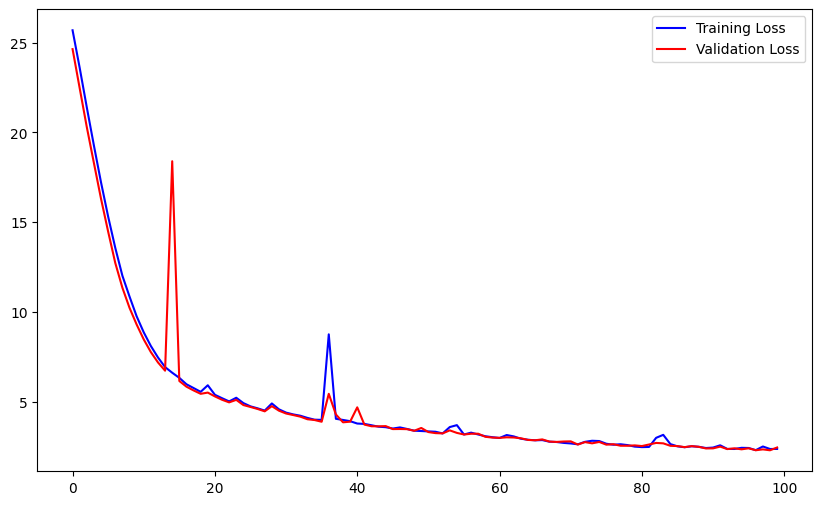

In [30]:
plt.plot(history_repar_bayes.history['loss'],color='b',
label='Training Loss')
plt.plot(history_repar_bayes.history['val_loss'],color='r',
label='Validation Loss')
plt.legend()
plt.show()

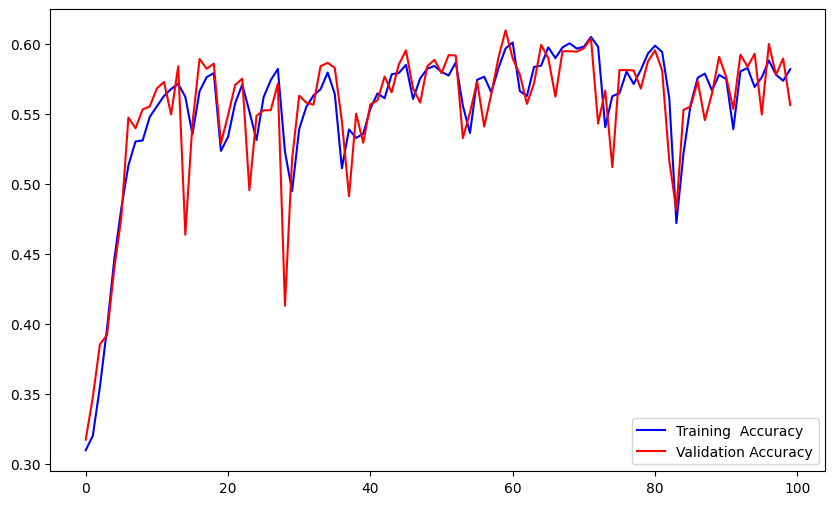

In [31]:
plt.plot(history_repar_bayes.history['accuracy'],color='b',
label='Training  Accuracy')
plt.plot(history_repar_bayes.history['val_accuracy'],color='r',
label='Validation Accuracy')
plt.legend()
plt.show()

## Model 3

Same architecture as Sarvesh's but with FLipout layers this time

### Build model

In [34]:
bayesian_model_flip = Sequential([
    get_convolutional_flipout_layer(
    input_shape=(69, 69, 3), divergence_fn=divergence_fn, f = 32, k =3),
    #MaxPooling2D(pool_size=(2, 2)),
    get_convolutional_flipout_layer(
    input_shape=(67, 67, 32), divergence_fn=divergence_fn, f = 64, k =3),
    MaxPooling2D(pool_size=(2, 2)),
    get_convolutional_flipout_layer(
    input_shape=(32, 32, 64), divergence_fn=divergence_fn, f = 64, k =3),
    MaxPooling2D(pool_size=(2, 2)),
    get_convolutional_flipout_layer(
    input_shape=(15, 15, 64), divergence_fn=divergence_fn, f = 64, k =3),
    MaxPooling2D(pool_size=(2, 2)),
    get_convolutional_flipout_layer(
    input_shape=(6, 6, 64), divergence_fn=divergence_fn, f = 64, k =3),
    MaxPooling2D(pool_size=(2, 2)),
    #get_convolutional_reparameterization_layer(
    #input_shape=(57, 57, 8), divergence_fn=divergence_fn, f = 8, k =5),
    #MaxPooling2D(pool_size=(5, 5)),
    Flatten(),
    get_dense_flipout_layer(divergence_fn = divergence_fn, units = 64),
    get_dense_flipout_layer(divergence_fn = divergence_fn, units = 32),
    get_dense_flipout_layer(divergence_fn = divergence_fn, units = tfpl.OneHotCategorical.params_size(10)),
    tfpl.OneHotCategorical(10, convert_to_tensor_fn=tfd.Distribution.mode)
])

In [35]:
print(bayesian_model_flip.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 67, 67, 32)        1792      
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 65, 65, 64)        36992     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_flipout_2 (Conv2DFlip (None, 30, 30, 64)        73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_flipout_3 (Conv2DFlip (None, 13, 13, 64)        73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 6, 6, 64)         

### Compile and fit model

In [36]:
bayesian_model_flip.compile(loss=nll,
              optimizer=Adam(),
              metrics=['accuracy'],
              experimental_run_tf_function=False)

In [37]:
history_flip_bayes = bayesian_model_flip.fit(x=X_train, y=y_train, batch_size = 32, epochs = 100, validation_data = (X_val,y_val), verbose=True)

Epoch 1/100
477/477 [==============================] - 27s 47ms/step - loss: 25.4745 - accuracy: 0.3118 - val_loss: 24.1944 - val_accuracy: 0.3568
Epoch 2/100
477/477 [==============================] - 22s 47ms/step - loss: 22.8383 - accuracy: 0.3739 - val_loss: 21.5411 - val_accuracy: 0.3911
Epoch 3/100
477/477 [==============================] - 23s 48ms/step - loss: 20.1941 - accuracy: 0.4444 - val_loss: 18.9248 - val_accuracy: 0.4807
Epoch 4/100
477/477 [==============================] - 22s 46ms/step - loss: 17.7251 - accuracy: 0.5027 - val_loss: 16.5589 - val_accuracy: 0.5294
Epoch 5/100
477/477 [==============================] - 22s 47ms/step - loss: 15.5311 - accuracy: 0.5225 - val_loss: 14.4765 - val_accuracy: 0.5514
Epoch 6/100
477/477 [==============================] - 23s 49ms/step - loss: 13.5476 - accuracy: 0.5553 - val_loss: 12.6903 - val_accuracy: 0.5358
Epoch 7/100
477/477 [==============================] - 22s 46ms/step - loss: 11.9092 - accuracy: 0.5592 - val_loss: 11

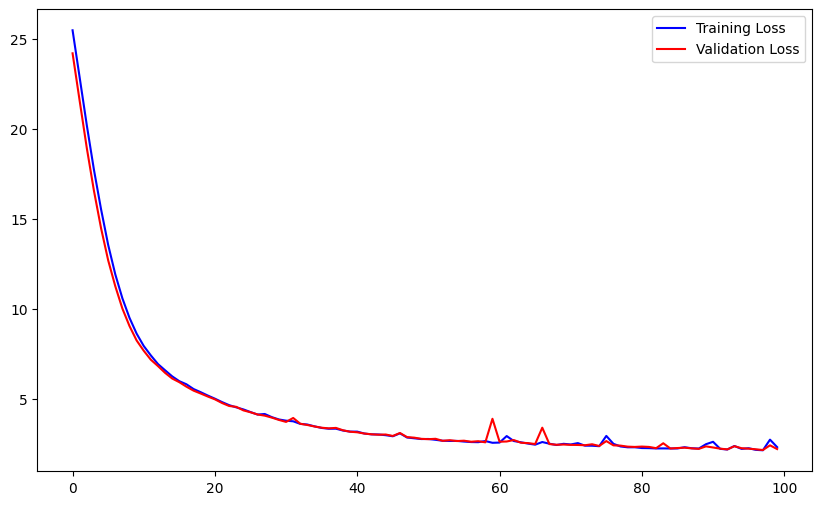

In [38]:
plt.plot(history_flip_bayes.history['loss'],color='b',
label='Training Loss')
plt.plot(history_flip_bayes.history['val_loss'],color='r',
label='Validation Loss')
plt.legend()
plt.show()

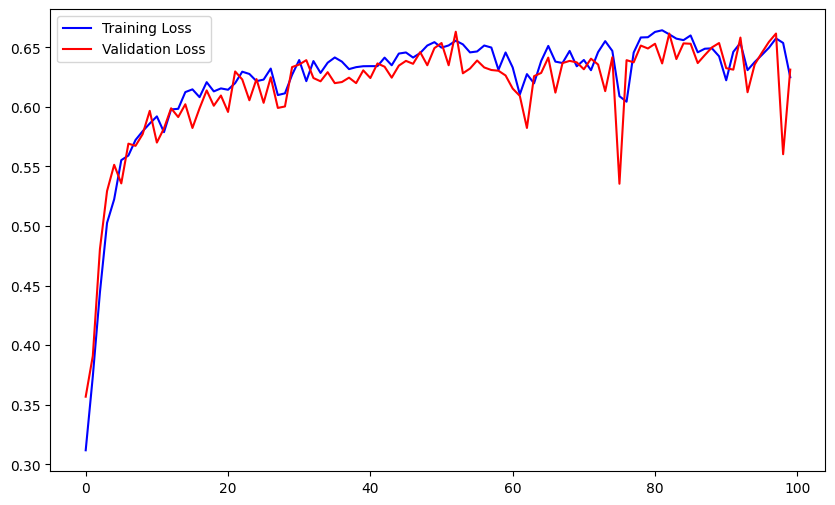

In [39]:
plt.plot(history_flip_bayes.history['accuracy'],color='b',
label='Training Loss')
plt.plot(history_flip_bayes.history['val_accuracy'],color='r',
label='Validation Loss')
plt.legend()
plt.show()

## Save weights of current best model

To make predictions as per need, build the model as per need and then just load the weights using *model.load_weights(PATH)*

In [48]:
PATH = './weights/best/bayesian_CNN_flipout_layers'
bayesian_model_flip.save_weights(PATH)

## Save metric logs of current best model(loss, accuracy, val_loss, val_accuracy)

In [49]:
df = pd.DataFrame.from_dict(history_flip_bayes.history)
df.to_csv("./logs/bayesian_cnn_flipout_logger.csv")